In [1]:
'''
调用高德api/调用hmap接口（hmap联系孙修飞/陈善文），通过订单开始和结束经纬度，获取最短路径，对比订单里程，给出异常订单的推荐阈值
考虑到异常路径一般不会出现在起步距离以内的订单中，故仅考虑实际里程大于3km的订单；
筛选出 zke_lch_jyqk - Hmap_dist > 1 （考虑了Hmap与高德Amap本身的导航距离差异）的里程差异分布图（司机比导航多开的路程），画箱线图并统计数值特征；
'''

import pandas as pd

full_fd = pd.read_csv("C:\\Users\\zhengqiushi\\Desktop\\hik\\21-08-23\\data\\ods_july_only_cut_cal_0701_0707_0826_1.csv")

C:\Users\zhengqiushi\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
# 筛去里程小于3km 且 尚未计算出HMAP的
full_fd = full_fd[(full_fd['Hmap_dist'] > 0) & (full_fd['zke_lch_jyqk'] > 3)]


In [3]:
def return_mile_bins():
    '''
    @brief 按照公里数进行分割
    @return bins
    '''
    cur_hour = 3
    hour_bins = []
    while cur_hour < 70:
        # per_bin = cur_hour * 3600 # pd.to_datetime(date_str + " {0}:00:00".format(cur_hour))
        hour_bins.append(cur_hour)
        cur_hour = cur_hour + 5
    return hour_bins

<AxesSubplot:>

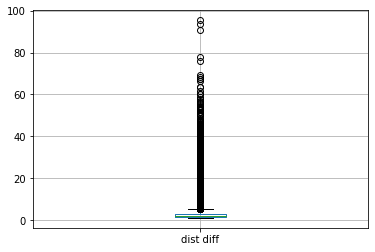

In [4]:
thresh = 1
# 计算实际里程与Hmap理想里程之差
dist_diff =pd.DataFrame([full_fd['did_bh'], full_fd['zke_lch_jyqk'], full_fd['zke_lch_jyqk'] - full_fd['Hmap_dist']]).T #
# 筛去距离之差小于1的，属于误差范围之内，不算异常订单
dist_diff = dist_diff[dist_diff['Unnamed 0'] > thresh]# ['did_bh'].values
box_ = pd.DataFrame([dist_diff[dist_diff['Unnamed 0'] > thresh]['Unnamed 0']]).T
# 画箱线图
box_.columns = pd.Series(['dist diff'])
box_ = box_[box_['dist diff'] < 100]
box_.boxplot()

In [5]:
# 按照里程长度进行划分
bins = return_mile_bins()

dff = dist_diff.groupby(pd.cut(dist_diff['zke_lch_jyqk'], bins=bins)) 

In [6]:
result_fd = pd.DataFrame()
# 给下标重命名
for name,group in dff:
    result_fd = pd.concat([result_fd, group['Unnamed 0']], axis= 1)
    result_fd.rename(columns={'Unnamed 0': name}, inplace = True)

print(result_fd)

          (3, 8]   (8, 13] (13, 18]  (18, 23] (23, 28] (28, 33] (33, 38]  \
2       1.573186       NaN      NaN       NaN      NaN      NaN      NaN   
7            NaN  2.249881      NaN       NaN      NaN      NaN      NaN   
11      3.388808       NaN      NaN       NaN      NaN      NaN      NaN   
14      1.229215       NaN      NaN       NaN      NaN      NaN      NaN   
24      2.649001       NaN      NaN       NaN      NaN      NaN      NaN   
...          ...       ...      ...       ...      ...      ...      ...   
472537   1.54467       NaN      NaN       NaN      NaN      NaN      NaN   
472603       NaN       NaN      NaN  2.718527      NaN      NaN      NaN   
472652   1.02419       NaN      NaN       NaN      NaN      NaN      NaN   
472663  1.271284       NaN      NaN       NaN      NaN      NaN      NaN   
472672       NaN  6.351887      NaN       NaN      NaN      NaN      NaN   

       (38, 43] (43, 48] (48, 53] (53, 58] (58, 63] (63, 68]  
2           NaN      NaN

<AxesSubplot:>

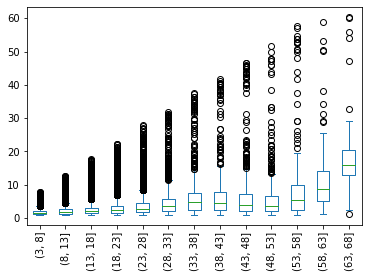

In [7]:
result_fd_plot = result_fd[(result_fd < 100) & (result_fd > 0)]

result_fd_plot.plot.box(rot = 90)


In [11]:
# 箱线图类型转换?
result_fd_plot = result_fd_plot.convert_dtypes()
result_csv = result_fd_plot.describe().T

result_csv["upper_thresh"] = -0.01
result_csv["upper_thresh"] = result_csv["75%"] + 1.5 * (result_csv["75%"] - result_csv["25%"])

# 打印行程段的describe
result_csv.T

,"(3, 8]","(8, 13]","(13, 18]","(18, 23]","(23, 28]","(28, 33]","(33, 38]","(38, 43]","(43, 48]","(48, 53]","(53, 58]","(58, 63]","(63, 68]"
count,63601.000000,28443.000000,15580.000000,8674.000000,4948.000000,2763.000000,1559.000000,999.000000,751.000000,585.000000,382.000000,178.000000,238.000000
mean,0.940102,1.285063,1.756655,2.246233,2.814924,3.794460,5.074239,5.438425,5.868609,5.089475,6.823353,10.709886,16.725359
std,0.856781,1.325033,1.881974,2.535030,3.249465,4.229400,5.555130,6.501895,7.977701,7.544191,10.635034,9.487961,8.142750
min,0.000034,0.000128,0.000356,0.000704,0.000871,0.000472,0.008368,0.006588,0.013207,0.043172,0.020630,0.186361,0.410624
25%,0.294923,0.398623,0.566892,0.682551,0.830380,1.113007,1.469747,1.563013,1.685592,1.231687,1.080569,4.552842,12.980198
50%,0.702028,0.926649,1.241414,1.544221,1.916451,2.578507,3.827732,3.512017,3.202317,2.889178,3.519510,8.468242,15.675832
75%,1.339262,1.734287,2.310195,2.919757,3.587362,4.940042,6.658485,7.148673,6.421596,5.517716,7.685782,13.820713,20.442441
max,7.859346,12.591456,17.771199,22.249807,27.911622,31.879625,37.620013,41.795241,46.717506,51.709087,57.610649,58.938212,60.397406
upper_thresh,2.905771,3.737782,4.925150,6.275566,7.722834,10.680593,14.441590,15.527163,13.525601,11.946759,17.593603,27.722520,31.635804


In [62]:
result_csv.T.to_csv("C:\\Users\\zhengqiushi\\Desktop\\hik\\21-08-23\\data\\task1_ods_july_diff_with_hmap_describe.csv")